# Kinsame with Siamese Networks

## Imports
All the imports are defined here

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import os
from tqdm import tqdm

## Helper functions
Set of helper functions

In [3]:
def imshow(img, text=None,should_save=False):
    if torch.is_tensor(img):
      img = img.numpy()
      img = np.transpose(img, (1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(img)
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [4]:
class Config():
    training = "./kinsame-assignment/kinsame-data-train.csv"
    testing = "./kinsame-assignment/kinsame-data-test.csv"
    images = "./kinsame-assignment/"
    model_save_path = "./kinsame-assignment/saved_model.pt"
    train_batch_size = 64
    train_number_epochs = 20
    train = True
    results = "./kinsame-assignment/results.pkl"

## Get the data

In [5]:
!gdown  1ScnG-T-VWkzSkwT-KSPcVeWUBq_kD_tK

Downloading...
From: https://drive.google.com/uc?id=1ScnG-T-VWkzSkwT-KSPcVeWUBq_kD_tK
To: /content/kinsame-assignment.zip
100% 44.4M/44.4M [00:00<00:00, 151MB/s]


In [ ]:
!unzip kinsame-assignment.zip -d kinsame-assignment

## Custom Dataset Class
This dataset generates a pair of images. 
0 -- for geniune pair  
1 -- for imposter pair

In [7]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,data_df, images_path, transform=None, should_invert=True):
        self.data_df = data_df    
        self.transform = transform
        self.should_invert = should_invert
        self.images_path = images_path
        
    def __getitem__(self,index):
        row = self.data_df.loc[index]

        img0 = Image.open(os.path.join(self.images_path, row.img1_path))
        img1 = Image.open(os.path.join(self.images_path,row.img2_path))

        # gt_data = [row.person1_id, row.person2_id, row.img1_path, row.img2_path, row.label]
        # img0 = img0.convert("L")
        # img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 ,torch.from_numpy(np.array([row.label],dtype=np.float32))
    
    def __len__(self):
        return len(self.data_df)

## Using Image Folder Dataset

In [8]:
train_df = pd.read_csv(Config.training)
# ContrastiveLoss defined (0 similar, 1 dissimilar) in our dataset the labels are opposite 
train_df.label.replace({0: 1, 1: 0}, inplace=True)
#making the dataset balansed
train_df = train_df.groupby('label').head(8867)
train_df.reset_index(inplace = True)
test_df = pd.read_csv(Config.testing)
test_df.label.replace({0: 1, 1: 0}, inplace=True)

In [9]:
# checking that the dataset is balanced
train_df.label.value_counts()

0    8867
1    8867
Name: label, dtype: int64

In [10]:
siamese_dataset = SiameseNetworkDataset(data_df=train_df,
                                        images_path=Config.images,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

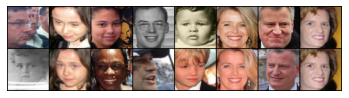

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [11]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [14]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=Config.train_batch_size)

In [16]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0001)

RuntimeError: ignored

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
if Config.train:
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    show_plot(counter,loss_history)

    torch.save(net, Config.model_save_path)

## Some simple testing
Running trained above network against test split and saving the results. 

In [ ]:
net = torch.load(Config.model_save_path)
net.eval()

siamese_dataset = SiameseNetworkDataset(data_df=test_df,
                                        images_path=Config.images,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0, batch_size=1,shuffle=False)

data = []

for i, (x0, x1 , label) in tqdm(enumerate(test_dataloader, 0),desc='calculating statistics'):
    row = test_df.loc[i]
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2).item()
    label = label.numpy()[0][0]
    euclidean_distance = round(euclidean_distance, 3)
    data.append([row.person1_id, 
                 row.person2_id, 
                 row.img1_path, 
                 row.img2_path, label, euclidean_distance])
  
data_df = pd.DataFrame(data, columns=['person1_id', 'person2_id',
                                      'img1_path', 'img2_path',
                                      'label', 'dissimilarity'])
data_df.to_pickle(Config.results)


In [ ]:
data_df = pd.read_pickle(Config.results)
data_df.sort_values(by=['dissimilarity'], inplace=True)

### Most similar images

In [ ]:
# 

for _, row in data_df.head(10).iterrows():


    img0 = torchvision.io.read_image(os.path.join(Config.images, row.img1_path))
    img1 = torchvision.io.read_image(os.path.join(Config.images,row.img2_path))

    concatenated = torch.cat((img0[None], img1[None]),0)
    text = 'Dissimilarity: {:.2f} Label: {}'.format(row.dissimilarity, row.label)
    imshow(torchvision.utils.make_grid(concatenated), text)


### Most different images

In [ ]:
# 

for _, row in data_df.tail(10).iterrows():


    img0 = torchvision.io.read_image(os.path.join(Config.images, row.img1_path))
    img1 = torchvision.io.read_image(os.path.join(Config.images,row.img2_path))

    concatenated = torch.cat((img0[None], img1[None]),0)
    text = 'Dissimilarity: {:.2f} Label: {}'.format(row.dissimilarity, row.label)
    imshow(torchvision.utils.make_grid(concatenated), text)

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(data_df.label.values,
                                                      data_df.dissimilarity.values)

plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Threshold')
plt.legend(loc='lower left')
plt.ylim([0,1])

In [ ]:

bins = np.linspace(0, 10, 100)
plt.hist(data_df.label.values, bins, alpha=0.5, label='gt')
plt.hist(data_df.dissimilarity.values, bins, alpha=0.5, label='pred')
plt.legend(loc='upper right')
plt.title("Distrebutions")
plt.xlabel("Similarity range")
plt.ylabel("Count")

plt.show()